# **Introduction to EDA with PANDAS python library**

In [100]:
!pip install dask[dataframe]
# import pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dask.dataframe import from_pandas


Dask and PANDAS

In [101]:
# from csv file
df_fish = pd.read_csv('/content/fish.csv')

ddf_fish = from_pandas(df_fish, npartitions=2)


In [102]:
ddf_fish.head()

,Fish_Catchment,Fish_River,Fish_SiteName,Fish_Latitude,Fish_Longitude,Fish_Area_m2,Fish_SurveyDate,Fish_Year,Common_Name,Latin_Name,Net_Number,Length_mm,Count,Unnamed: 13,Unnamed: 14
0,River Trent,River Trent,Attenborough,52.895535,-1.22996,84,19/05/1999,1999,Bleak,Alburnus alburnus,1,23.0,1.0,NaN,NaN
1,River Trent,River Trent,Attenborough,52.895535,-1.22996,84,19/05/1999,1999,Bleak,Alburnus alburnus,1,23.0,1.0,NaN,NaN
2,River Trent,River Trent,Attenborough,52.895535,-1.22996,84,19/05/1999,1999,Bleak,Alburnus alburnus,1,23.0,1.0,NaN,NaN
3,River Trent,River Trent,Attenborough,52.895535,-1.22996,84,19/05/1999,1999,Bleak,Alburnus alburnus,1,23.0,1.0,NaN,NaN
4,River Trent,River Trent,Attenborough,52.895535,-1.22996,84,19/05/1999,1999,Bleak,Alburnus alburnus,1,23.0,1.0,NaN,NaN


In [103]:
# ddf_fish.dropna()
# ddf_fish.dropna()

ddf_fish['name'] = ddf_fish.Common_Name.apply(str.lower, meta=ddf_fish).compute()
ddf_fish = ddf_fish.query('`name` != "barbel" and `name` != "pike"')

In [104]:
ddf_fish.head()

,Fish_Catchment,Fish_River,Fish_SiteName,Fish_Latitude,Fish_Longitude,Fish_Area_m2,Fish_SurveyDate,Fish_Year,Common_Name,Latin_Name,Net_Number,Length_mm,Count,Unnamed: 13,Unnamed: 14,name
0,River Trent,River Trent,Attenborough,52.895535,-1.22996,84,19/05/1999,1999,Bleak,Alburnus alburnus,1,23.0,1.0,NaN,NaN,bleak
1,River Trent,River Trent,Attenborough,52.895535,-1.22996,84,19/05/1999,1999,Bleak,Alburnus alburnus,1,23.0,1.0,NaN,NaN,bleak
2,River Trent,River Trent,Attenborough,52.895535,-1.22996,84,19/05/1999,1999,Bleak,Alburnus alburnus,1,23.0,1.0,NaN,NaN,bleak
3,River Trent,River Trent,Attenborough,52.895535,-1.22996,84,19/05/1999,1999,Bleak,Alburnus alburnus,1,23.0,1.0,NaN,NaN,bleak
4,River Trent,River Trent,Attenborough,52.895535,-1.22996,84,19/05/1999,1999,Bleak,Alburnus alburnus,1,23.0,1.0,NaN,NaN,bleak


In [105]:
def load_emissions(path, element):
  df_emissions = pd.read_excel(path, skiprows=lambda x: (x<3) or (x>28), sheet_name=element, usecols='A:AJ')
  df_emissions_T = df_emissions.T
  df_emissions_T.columns = df_emissions_T.iloc[2,:] # set the new first row as the column names
  df_emissions_T = df_emissions_T.iloc[3:,:] # remove first two rows
  df_emissions_T.index.name = 'year' # set index name
  df_emissions_T.columns.name =  'emission_type' # set column name
  df_emissions_T = df_emissions_T.dropna(axis=1, how='all') # remove empty columns

  return df_emissions_T.iloc[:,-1].reset_index()

path = '/content/emissions.xlsx'
df_em = load_emissions(path, 'Copper')
elements = ['Lead', 'Mercury', 'Nickel', 'Selenium', 'Vanadium', 'Zinc']
emissions_names = {'Total mercury emissions':'Mercury', 'Total copper emissions': 'Copper', 'Total lead emissions':'Lead',
                   'Total nickel emissions':'Nickel', 'Total selenium emissions': 'Selenium', 'Total vanadium emissions':'Vanadium',
                   'Total zinc emissions':'Zinc'}
for e in elements:
  df_em = df_em.merge(load_emissions(path, e), on='year', how='outer')
df_em = df_em.rename(columns=emissions_names)

ddf_em = from_pandas(df_em, npartitions=10)
# excel files are more complex than csv so you need to be more specific in what you want

In [106]:

df_fish_length_per_year = ddf_fish.groupby(['Fish_Year', 'name']).Length_mm.mean().reset_index()

merged = df_fish_length_per_year.merge(ddf_em, left_on='Fish_Year',right_on='year', how='inner')

df_fish_length_per_year.head()
merged.head()

/usr/local/lib/python3.10/dist-packages/dask/dataframe/core.py:8164: UserWarning: Insufficient elements for `head`. 5 elements requested, only 0 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


,Fish_Year,name,Length_mm,year,Copper,Lead,Mercury,Nickel,Selenium,Vanadium,Zinc


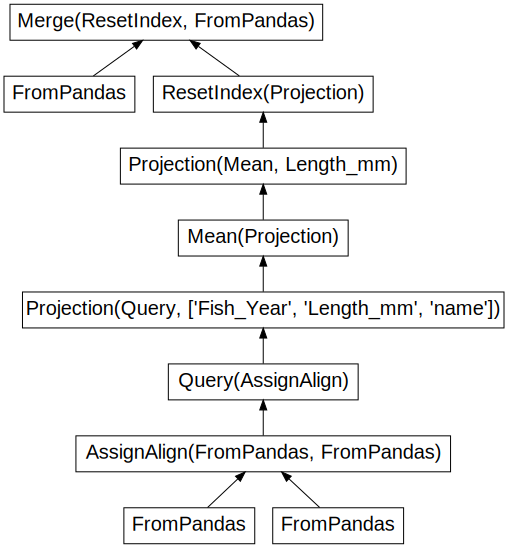

In [107]:
merged.visualize()

In [108]:
%time _= merged.compute()
df_merged = merged.compute()

fish_lengths = df_merged.pivot(index='year', columns='name', values=['Length_mm'] ).drop_duplicates()
fish_lengths.columns = fish_lengths.columns.droplevel(0)
fish_lengths = fish_lengths.merge(df_merged[['year', 'Copper'] + elements], on='year', how='outer')
correlations = fish_lengths.corr()


CPU times: user 659 ms, sys: 85.1 ms, total: 744 ms
Wall time: 1.02 s


In [109]:
df_merged

,Fish_Year,name,Length_mm,year,Copper,Lead,Mercury,Nickel,Selenium,Vanadium,Zinc
0,1999,10-spined stickleback,26.625000,1999,726.862,576.124,9.184,421.876,31.382,1183.359,862.261
1,1999,3-spined stickleback,30.599315,1999,726.862,576.124,9.184,421.876,31.382,1183.359,862.261
2,1999,bleak,26.873176,1999,726.862,576.124,9.184,421.876,31.382,1183.359,862.261
3,1999,bullhead,31.166667,1999,726.862,576.124,9.184,421.876,31.382,1183.359,862.261
4,1999,chub,27.000757,1999,726.862,576.124,9.184,421.876,31.382,1183.359,862.261
...,...,...,...,...,...,...,...,...,...,...,...
24,2017,10-spined stickleback,21.000000,2017,751.029,127.621,4.299,186.09,10.477,762.766,574.479
25,2017,bullhead,39.000000,2017,751.029,127.621,4.299,186.09,10.477,762.766,574.479
26,2017,ruffe,28.000000,2017,751.029,127.621,4.299,186.09,10.477,762.766,574.479
27,2017,silver bream,65.000000,2017,751.029,127.621,4.299,186.09,10.477,762.766,574.479


<Axes: >

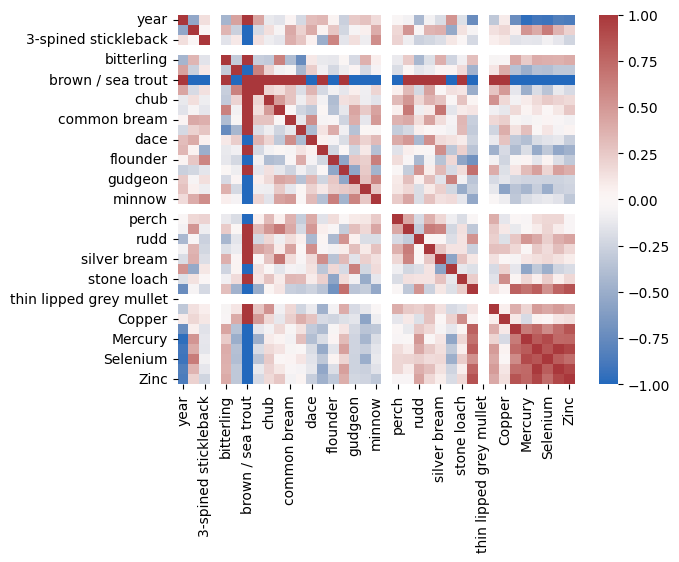

In [110]:
import seaborn as sns
sns.heatmap(correlations, cmap=sns.color_palette("vlag", as_cmap=True))

Tasks:
1. Increase number of partitions to 10
2. Does this speed up compute?  --- No
3. Filter out barbel as well
4. Does this slow down compute  ---- Yes
